In [1]:
import math
import os
import ast

import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from matplotlib import pyplot as plt
from sklearn.metrics import r2_score

from geopy.geocoders import Nominatim

%matplotlib inline
from IPython.display import display

In [2]:
data = pd.read_csv('airbnbmark1.csv', dtype={
        'host_acceptance_rate':str,
        'weekly_price':str,
        'monthly_price':str,
        'license':str,
        'jurisdiction_names':str,
        }
    )
data.shape

(153254, 106)

In [3]:
def dollar_price_to_float(x):
    if pd.isna(x):
        return x
    elif type(x) == float:
        return x
    else:
        assert type(x) == str
        x = x[1:].replace(',', '')
        return float(x)

dollars = ['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people']
for column in dollars:
    data[column] = data[column].apply(dollar_price_to_float)

def percentage_to_float(x):
    if pd.isna(x):
        return x
    return float(x[:-1])

data['host_acceptance_rate'] = data['host_acceptance_rate'].apply(percentage_to_float)
data[['price', 'weekly_price', 'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people', 'host_acceptance_rate']]


,price,weekly_price,monthly_price,security_deposit,cleaning_fee,extra_people,host_acceptance_rate
0,225.0,1995.0,NaN,350.0,95.0,0.0,38.0
1,89.0,575.0,2100.0,500.0,NaN,0.0,96.0
2,200.0,NaN,NaN,300.0,125.0,100.0,71.0
3,60.0,NaN,NaN,450.0,0.0,30.0,67.0
4,79.0,470.0,NaN,NaN,15.0,12.0,100.0
...,...,...,...,...,...,...,...
153249,150.0,NaN,NaN,0.0,0.0,0.0,100.0
153250,149.0,NaN,NaN,NaN,NaN,0.0,99.0
153251,188.0,NaN,NaN,NaN,NaN,0.0,NaN
153252,1100.0,NaN,NaN,NaN,NaN,0.0,100.0


In [4]:
s = set()
for item in data['host_verifications']:
    new_list = ast.literal_eval(item)
    if new_list is not None:
        s = s.union(set(new_list))
print(len(s))
s

19


{'email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'reviews',
 'selfie',
 'sent_id',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie'}

In [5]:
def log(*args, **kwargs):
    #print(f"[log]: ",end='')
    #print(*args, **kwargs)
    pass

amenities_pool = np.zeros((data.shape[0], 150))
amenities_dict = {}
amenities_dict_reverse = {}
amenities_list = ['' for _ in range(150)]
for index, item in enumerate(data['amenities']):
    if item == '{}':
        continue
    new_list = list(map(str.strip,item[1:-1].replace('"','').replace("'",'').split(',')))
    log("index, item=", index, item)
    for s in new_list:
        if s not in amenities_dict:
            log('s=', s)
            orig_n_amenities = len(amenities_dict)
            amenities_dict[s] = orig_n_amenities
            amenities_dict_reverse[orig_n_amenities] = s
            amenities_list[orig_n_amenities] = s
            log(f"matched: list[{orig_n_amenities}] = {s}")
        amenities_pool[index, amenities_dict[s]] = 1
    
amenities_df = pd.DataFrame(amenities_pool, columns=amenities_list)
amenities_df

,TV,Wifi,Air conditioning,Kitchen,Paid parking off premises,Free street parking,Heating,Family/kid friendly,Smoke detector,Carbon monoxide detector,...,Bottled water,Mini fridge,Electric profiling bed,Mobile hoist,Washer / Dryer,Pool with pool hoist,Ceiling hoist,Record player,Turndown service,Snacks
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153249,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153250,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153251,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
153252,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
def verify_amenities_df(amenities_df, data_amenities):
    for i in range(amenities_df.shape[0]):
        for j,column in enumerate(amenities_df):
            if amenities_df.iloc[i,j] == 1 and column in list(map(str.strip,data_amenities[i][1:-1].replace('"','').replace("'",'').split(','))):
                continue
            elif amenities_df.iloc[i,j] == 0 and column not in list(map(str.strip,data_amenities[i][1:-1].replace('"','').replace("'",'').split(','))):
                continue
            else:
                print(i, j, column)
                display(amenities_df.iloc[i, :], column)
                return
#verify_amenities_df(amenities_df, data['amenities'])


In [7]:
columns_to_use = [
    'host_is_superhost', #t/f, missing=204
    'host_identity_verified', #t/f, missing=204
    'latitude', #numerical value(float), missing=0, Quantiles: [40.5, 40.7, 40.7, 40.8, 40.9]
    'longitude', #numerical value(float), missing=0, Quantiles: [-74.2, -74, -74, -73.9, -73.7]
    'is_location_exact', #t/f, missing=0
    'property_type', #categorical value, nunique=40, most comon: Apartment(78%)
    'room_type', #categorical value, nunique=4, most common: Entire home/apt(52%)
    'accommodates', #numerical value(int), missing=0, Quantiles: [1, 2, 2, 4, 22]
    'bathrooms', #numerical value(float), missing=150, Quantiles: [0,1,1,1,15.5]
    'bedrooms', #numerical value(int), missing=220, Quantiles: [0,1,1,1,21]
    'beds', #numerical value(int), missing=1033(1%), Quantiles: [0,1,1,2, 40]
    'bed_type', #categorical value, nunique=5, most common: Real Bed(99%)
    'price', #numerical value(int), missing=0, Quantiles: [0, 69, 105, 175, 10000]
    'number_of_reviews', #numerical value(int), missing=0, Quantiles: [0,1,6,25,730]
    'review_scores_rating', #numerical value(int), missing=22%, Quantiles:[20,92,96,100,100]
    'instant_bookable', #t/f, missing=0
    'cancellation_policy', #categorical value, nunique=6, most common:strict_14_with_grace_p...(46%)
    ]
data_use = data[columns_to_use]

data_use = data_use.dropna()
data_use = data_use.drop_duplicates()
data_use = data_use[data_use['price'] != 0]

one_hot_encodings = pd.get_dummies(data_use[['property_type', 'room_type','bed_type','cancellation_policy']])
data_use = pd.concat([one_hot_encodings, data_use],axis=1)
#data_use = pd.concat([one_hot_encodings, data_use, amenities_df])
try:
    data_use = data_use.drop(['translation missing: en.hosting_amenity_49', 'translation missing: en.hosting_amenity_50'], axis=1)
except KeyError:
    pass
data_use = data_use.drop(['property_type', 'room_type', 'bed_type', 'cancellation_policy'], axis=1)

tf_columns = ['host_is_superhost', 'host_identity_verified', 'is_location_exact', 'instant_bookable']
data_use[tf_columns] = (data_use[tf_columns]=='t').astype(int)

data_use = data_use[data_use['number_of_reviews'] >= 10]
data_use = data_use.drop(['number_of_reviews'], axis=1)

data_use = data_use.astype(np.float32)
data_use


,property_type_Aparthotel,property_type_Apartment,property_type_Barn,property_type_Bed and breakfast,property_type_Boat,property_type_Boutique hotel,property_type_Bungalow,property_type_Cabin,property_type_Camper/RV,property_type_Casa particular (Cuba),...,latitude,longitude,is_location_exact,accommodates,bathrooms,bedrooms,beds,price,review_scores_rating,instant_bookable
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.753620,-73.983772,0.0,1.0,1.0,0.0,1.0,225.0,94.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.685139,-73.959763,1.0,3.0,1.0,1.0,4.0,89.0,90.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.747669,-73.974998,0.0,2.0,1.0,1.0,1.0,200.0,90.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.764889,-73.984932,1.0,2.0,1.0,1.0,1.0,79.0,84.0,0.0
5,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.801781,-73.967232,1.0,1.0,1.0,1.0,1.0,79.0,98.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150752,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.737751,-74.005363,1.0,5.0,1.0,1.0,3.0,226.0,100.0,1.0
150903,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.663639,-73.893990,1.0,2.0,1.0,1.0,1.0,50.0,98.0,1.0
151139,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.795200,-73.948410,0.0,2.0,2.0,1.0,1.0,70.0,90.0,1.0
151218,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,40.760021,-73.989830,1.0,6.0,1.0,2.0,3.0,500.0,100.0,0.0


In [8]:
data_use = data_use.drop(data_use.columns[data_use.max() - data_use.min() == 0], axis=1)

In [9]:
learning_rate      = 0.001
minibatch_size     = 1000
n_data             = 50000
train_ratio        = 0.75
n_epochs           = 500
n_columns          = data_use.shape[1]
target             = ['price']
n_in_vector        = n_columns - len(target)
n_out_vector       = len(target)

In [10]:
saved_mean_std = pd.DataFrame([data_use.mean(), data_use.std()], index=['mean', 'std'])
data_use.columns[data_use.std() == 0]

Index([], dtype='object')

In [11]:
def encode(data_in):
    data = data_in.copy()
    for column in data.columns:
        data[column] = (data[column] - saved_mean_std[column]['mean']) / saved_mean_std[column]['std']
    return data

def decode(data_in):
    data = data_in.copy()
    for column in data.columns:
        data[column] = data[column] * saved_mean_std[column]['std'] + saved_mean_std[column]['mean']
    return data

In [12]:
class dataset(Dataset):
    def __init__(self, data):
        #self.encoded    = encode(data)
        self.encoded    = data
        self.in_vector  = self.encoded.drop(target, axis=1).values
        self.out_vector = self.encoded[target].values

    def __getitem__(self, index):
        return self.in_vector[index, :], self.out_vector[index, :]
    
    def __len__(self):
        return self.encoded.shape[0]

In [13]:
train_number     = int(train_ratio * n_data)

dataset_train    = dataset(data_use.iloc[:train_number, :])
dataset_test     = dataset(data_use.iloc[train_number:n_data, :])
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=minibatch_size, shuffle=True, drop_last=True)
dataloader_test  = torch.utils.data.DataLoader(dataset_test,  batch_size=minibatch_size, shuffle=True, drop_last=False)

if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [14]:
class Network(nn.Module):
    def __init__(self,in_size,out_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_size, in_size//2),
            nn.ReLU(),
            nn.BatchNorm1d(in_size//2),
            nn.Linear(in_size//2, in_size//4),
            nn.ReLU(),
            nn.BatchNorm1d(in_size//4),
            nn.Linear(in_size//4, out_size),
        )
    def initialize_weight(self):
        for m in self.network.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.xavier_uniform_(m.bias, 1)

    def forward(self, x):
        return self.network(x)

In [15]:
network = Network(n_in_vector, n_out_vector).to(device)
optimizer = torch.optim.Adagrad(network.parameters(), lr=learning_rate)

In [16]:
loss_train_epoch_mean = []
loss_train_epoch_std  = []
r2_train_epoch_mean   = []
r2_train_epoch_std    = []
loss_test_epoch_mean  = []
loss_test_epoch_std   = []
r2_test_epoch_mean    = []
r2_test_epoch_std     = []
for i in tqdm(range(n_epochs)):
    network.train()
    for idx, (in_value, target_value) in enumerate(dataloader_train):
        in_tensor        = in_value.to(device)
        target_tensor    = target_value.to(device)
        loss_train_batch = []
        predict          = network(in_tensor)
        loss             = nn.MSELoss()(predict, target_tensor)
        loss_train_batch.append(loss.item())
    loss_train_epoch_mean.append(np.mean(loss_train_batch))
    loss_train_epoch_std.append(np.std(loss_train_batch))
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    network.eval()
    for idx, (in_value, target_value) in enumerate(dataloader_test):
        loss_test_batch = []
        in_tensor  = in_value.to(device)
        target_tensor     = target_value.to(device)
        prediction = network(in_tensor)
        loss       = nn.MSELoss()(prediction, target_tensor)
        loss_test_batch.append(loss.item())
    loss_test_epoch_mean.append(np.mean(loss_test_batch))
    loss_test_epoch_std.append(np.std(loss_test_batch))

100%|██████████| 500/500 [03:33<00:00,  2.34it/s]


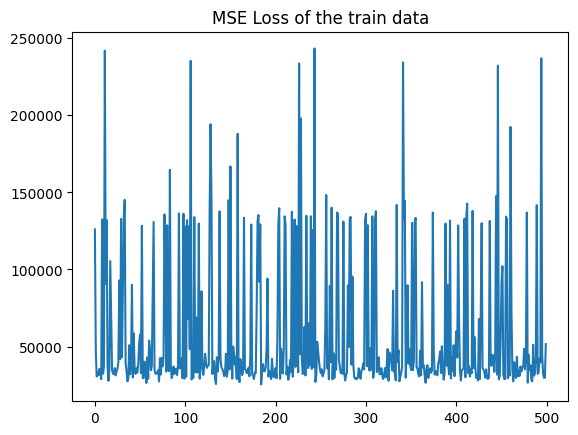

In [17]:
plt.title("MSE Loss of the train data")
loss_train_epoch_mean = np.array(loss_train_epoch_mean)
loss_train_epoch_std = np.array(loss_train_epoch_std)
plt.plot(loss_train_epoch_mean)
plt.fill_between(x=range(len(loss_train_epoch_mean)),y1=loss_train_epoch_mean+loss_train_epoch_std,y2=loss_train_epoch_mean-loss_train_epoch_std, alpha=0.5)
plt.show()

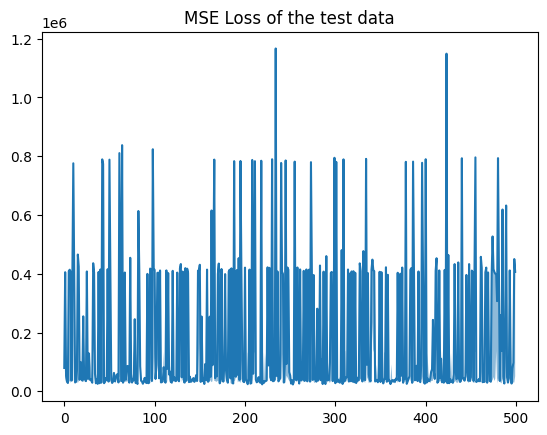

In [18]:
plt.title("MSE Loss of the test data")
loss_test_epoch_mean = np.array(loss_test_epoch_mean)
loss_test_epoch_std = np.array(loss_test_epoch_std)
plt.plot(loss_test_epoch_mean)
plt.fill_between(x=range(len(loss_test_epoch_mean)),y1=loss_test_epoch_mean+loss_test_epoch_std,y2=loss_train_epoch_mean-loss_train_epoch_std, alpha=0.5)
plt.show()

In [19]:
print("final MSE Loss:", loss_test_epoch_mean[-1])

final MSE Loss: 406637.0625


In [21]:
data.columns[data.columns.str.contains('price')]

Index(['price', 'weekly_price', 'monthly_price'], dtype='object')

In [22]:
data.columns[data.columns.str.contains('review')]

Index(['number_of_reviews', 'number_of_reviews_ltm', 'first_review',
       'last_review', 'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [27]:
data_price_review=data[data['review_scores_rating'].notna()][['price','review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']]

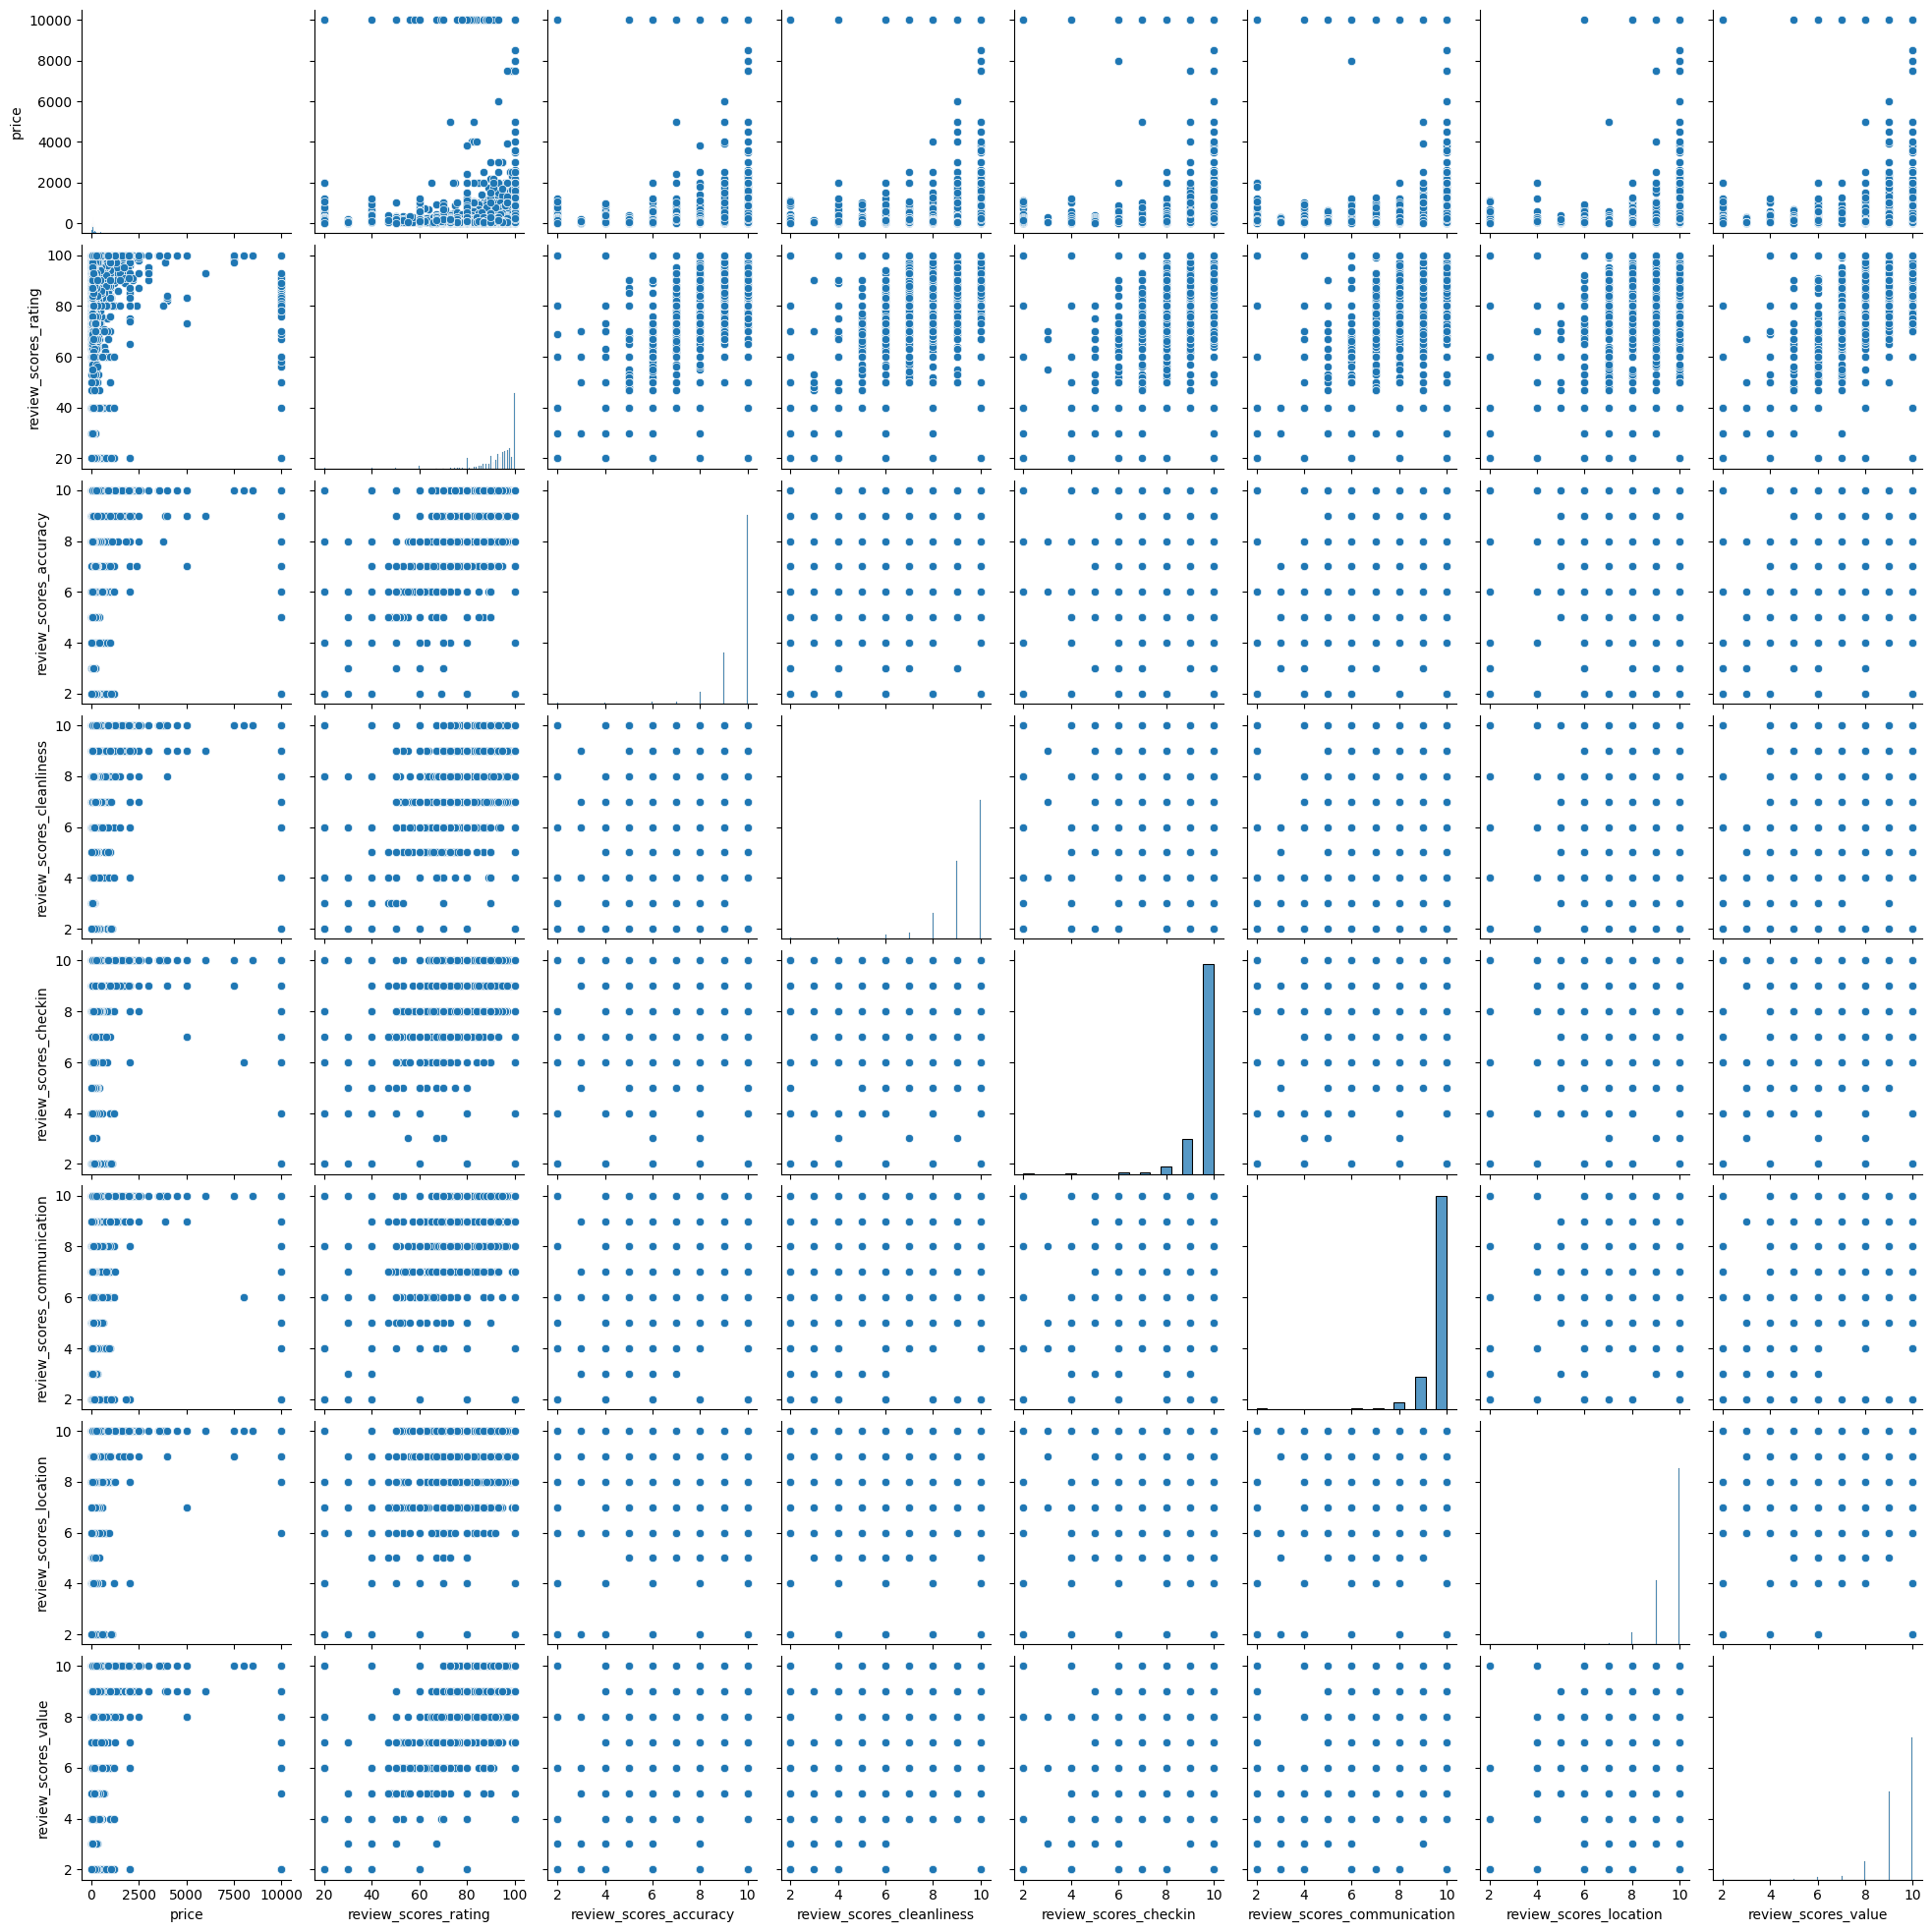

In [32]:
import seaborn as sns
sns.pairplot(data=data_price_review)
plt.show()